In [1]:
# DS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.metrics.pairwise import cosine_similarity

from my_utils import *

In [2]:
print(VERSION)

v3.0


## Load Data

In [3]:
gdf_zoning = read_csv_to_gdf(f"result/gdf_zoning_{VERSION}.csv").to_crs("epsg:2263")
df_zonevec = pd.read_csv(f"result/df_zonevec_{VERSION}.csv")

# Zoning Vectors

In [4]:
gdf_zoning_vec = pd.merge(gdf_zoning, df_zonevec, 
                           left_index=True, right_on="id",how='inner') \
                   .reset_index().rename(columns={"index":"zoning_ID"})

## Cos KMeans Clustering

In [5]:
X = gdf_zoning_vec.loc[:,[f"ZoneVec_{i+1}" for i in range(VEC_DIM)]]

In [6]:
# find best cluster numbers
kmeans_per_k = [Cosine_KMeans(nclust= k).fit(X) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

D:\Miniconda\envs\sds20\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Text(0.55, 0.55, 'Elbow')

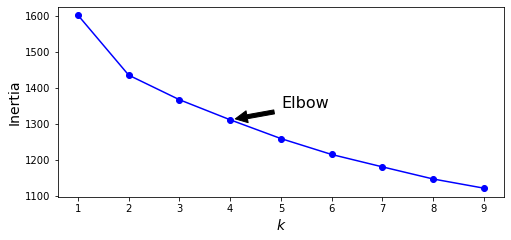

In [7]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1))

## Visualization

In [8]:
gdf_zoning_vec["clu"] = Cosine_KMeans(nclust= 5).fit(X).labels_
gdf_zoning_vec["clu"] = gdf_zoning_vec["clu"].astype('category')

<AxesSubplot:>

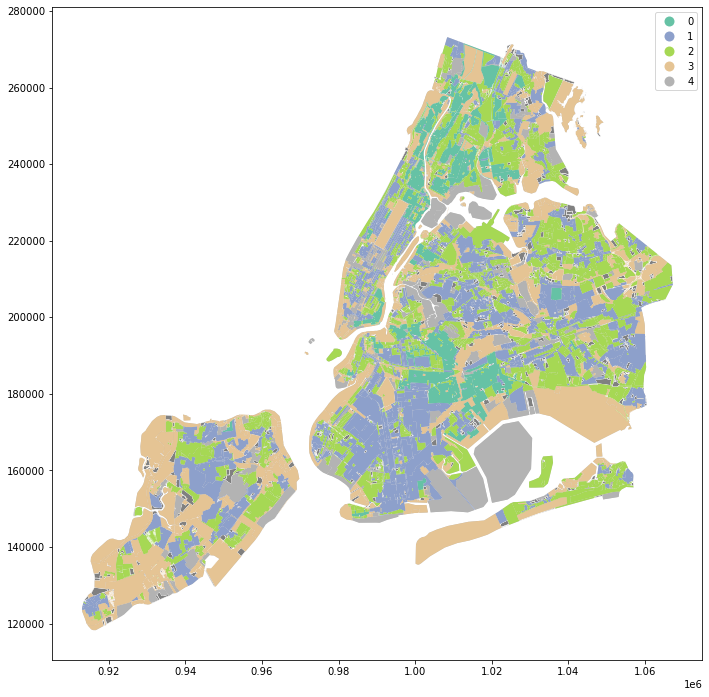

In [9]:
fig,ax=plt.subplots(figsize=(15,12))
# no data area
gdf_zoning.plot(ax=ax,alpha=1,linewidth=0.5,zorder=1,facecolor="grey", edgecolors="w")
# clusterd
gdf_zoning_vec.plot(column='clu', cmap='Set2', markersize=1, ax=ax,legend=True,alpha=1,zorder=2)

## Classification Accuracy

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score

In [12]:
X = gdf_zoning_vec[[f"ZoneVec_{i+1}" for i in range(VEC_DIM)]]
y = gdf_zoning_vec.zone_c.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
acc = matrix.diagonal()/matrix.sum(axis=1)
print(acc)
print(accuracy_score(y_test,y_pred))
print(cohen_kappa_score(y_test,y_pred))

[0.27272727 0.         0.         0.25925926 0.8006135  0.32489451
 0.4       ]
0.44686411149825783
0.28293475609276264


# POI Vectors

In [13]:
df_poivec = pd.read_csv(f"result/df_poivec_{VERSION}.csv").set_index("code")

In [14]:
# create distance matrix for clustering
length  = df_poivec.shape[0]

mt = np.zeros([length,length])
for i in range(length):
    for j in range(length):
        mt[i,j] = cosine_similarity(np.array(df_poivec.iloc[i,:]).reshape(1, -1), 
                                    np.array(df_poivec.iloc[j,:]).reshape(1, -1))

df_mt = pd.DataFrame(mt).set_index(df_poivec.index)

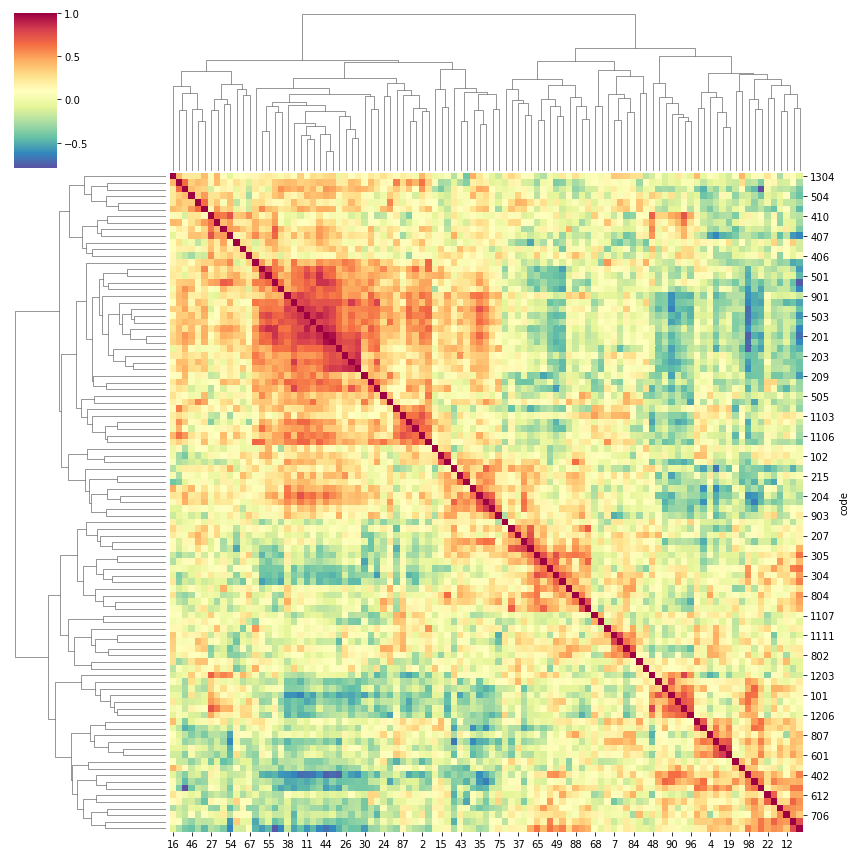

In [15]:
g = sns.clustermap(df_mt, cmap="Spectral_r",figsize=(12,12))